In [ ]:
!pip install keras-nlp tensorflow numpy pandas tqdm plotly matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 112.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This b

In [ ]:
!pip install nltk

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # or "tensorflow" or "torch"

import keras_nlp
import keras
import tensorflow as tf

import numpy as np
import pandas as pd
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px

In [ ]:
class CFG:
    seed = 42  # Random seed
    preset = "deberta_v3_extra_small_en" # Name of pretrained models
    sequence_length = 512  # Input sequence length
    epochs = 10 # Training epochs
    batch_size = 16  # Batch size
    scheduler = 'cosine'  # Learning rate scheduler
    label2name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
    name2label = {v:k for k, v in label2name.items()}
    class_labels = list(label2name.keys())
    class_names = list(label2name.values())

In [ ]:
keras.utils.set_random_seed(CFG.seed)

In [ ]:
import re
import json
import ast
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
import numpy as np
import pandas as pd

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

def convertir_a_lista(texto):
    try:
        # Attempt to parse the string as JSON
        return json.loads(texto)
    except json.JSONDecodeError:
        # If it fails, return the text wrapped in a list
        return [texto]  # Wrap the text as a list to maintain consistency

STOP_WORDS = set(stopwords.words('english'))

extra_stopwords = {'use', 'used', 'data', 'help', 'need', 'time', 'may', 'one', 'would', 'could', 'like', 'also', 'using', 'make', 'please', 'i', 'write'}

# Combine NLTK stopwords with the additional unwanted words
STOPWORDS = STOP_WORDS.union(extra_stopwords)

def limpiar_texto(texto: str) -> str:
    if not texto:
        return ""

    # Vectorized operations for text cleaning
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+|https\S+|[#@']", "", texto, flags=re.MULTILINE)  # Remove URLs, hashtags, etc.
    texto = texto.encode('ascii', 'ignore').decode('ascii')  # Remove non-ASCII
    texto = texto.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # Tokenization and stopword removal using the precomputed stopwords
    tokens = [word for word in word_tokenize(texto) if word not in STOP_WORDS]

    texto_limpio = ' '.join(tokens)
    return texto_limpio

def procesar_respuesta(responses: pd.Series) -> pd.Series:
    # Convert LaTeX to text and then clean the list without apply
    responses = responses.str.replace(r'\\(begin|end)\{itemize\}', '', regex=True)\
                         .str.replace(r'\\item\s*', '\n', regex=True)\
                         .str.replace(r'\\[a-zA-Z]+\{[^}]*\}', '', regex=True)\
                         .str.replace(r'\s+', ' ', regex=True).str.strip()

    # Convert JSON strings to lists with error handling
    responses = responses.map(convertir_a_lista)

    # Clean the text inside the lists using numpy's vectorize to avoid apply
    responses = responses.map(lambda lista: np.vectorize(limpiar_texto)(lista) if isinstance(lista, list) else lista)

    return responses

def limpiar_df(df: pd.DataFrame) -> pd.DataFrame:
    # Vectorized operations for cleaning prompts and responses
    df['prompt'] = df['prompt'].apply(ast.literal_eval)
    df['prompt_limpio'] = df['prompt'].apply(lambda lista: [limpiar_texto(texto) for texto in lista])

    # Convert LaTeX to text and clean responses directly
    df['response_a_limpio'] = procesar_respuesta(df['response_a'])
    df['response_b_limpio'] = procesar_respuesta(df['response_b'])

    return df

BASE_PATH = '/content/drive/MyDrive/Data science/p2'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df = limpiar_df(df)

In [ ]:
# Take the first prompt and its associated response
df["prompt_limpio"] = df.prompt_limpio.map(lambda x: x[0])
df["response_a_limpio"] = df.response_a_limpio.map(lambda x: x[0])
df["response_b_limpio"] = df.response_b_limpio.map(lambda x: x[0])
df["len_prompt"] = df.prompt_limpio.map(lambda x: len(x))
df["len_response_a"] = df.response_a_limpio.map(lambda x: len(x))
df["len_response_b"] = df.response_b_limpio.map(lambda x: len(x))
df["sentiment_prompt"] = df.prompt_limpio.map(lambda x: analyzer.polarity_scores(x)["compound"])
df["sentiment_response_a"] = df.response_a_limpio.map(lambda x: analyzer.polarity_scores(x)["compound"])
df["sentiment_response_b"] = df.response_b_limpio.map(lambda x: analyzer.polarity_scores(x)["compound"])

# Label conversion
df["class_name"] = df[["winner_model_a", "winner_model_b" , "winner_tie"]].idxmax(axis=1)
df["class_label"] = df.class_name.map(CFG.name2label)

# Show Sample
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,prompt_limpio,response_a_limpio,response_b_limpio,len_prompt,len_response_a,len_response_b,sentiment_prompt,sentiment_response_a,sentiment_response_b,class_name,class_label
0,30192,gpt-4-1106-preview,gpt-4-0613,[Is it morally right to try to have a certain ...,"[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,morally right try certain percentage females m...,question whether morally right aim certain per...,ai dont personal beliefs opinions however tell...,65,2193,509,0.2732,0.9835,0.7960,winner_model_a,0
1,53567,koala-13b,gpt-4-0613,[What is the difference between marriage licen...,"[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,difference marriage license marriage certificate,marriage license legal document allows couple ...,marriage license marriage certificate two diff...,48,467,897,0.0000,0.6908,0.9231,winner_model_b,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,[explain function calling. how would you call ...,"[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,explain function calling would call function,function calling process invoking executing fu...,function calling process invoking function pro...,44,561,1198,0.0000,0.1280,-0.2500,winner_tie,2
3,96401,llama-2-13b-chat,mistral-7b-instruct,[How can I create a test set for a very rare c...,"[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,create test set rare category want build class...,creating test set rare category challenging ma...,building classifier rare category creating tes...,51,2175,1000,0.3400,0.9868,0.9892,winner_model_a,0
4,198779,koala-13b,gpt-3.5-turbo-0314,[What is the best way to travel from Tel-Aviv ...,"[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,best way travel telaviv jerusalem car bus plane,best way travel tel aviv jerusalem depends per...,best way travel telaviv jerusalem depends pers...,47,851,512,0.6369,0.9622,0.9118,winner_model_b,1


In [ ]:
df = df.drop(columns=["prompt", "response_a", "response_b", "winner_model_a", "winner_model_b", "winner_tie"])
df.head()

,id,model_a,model_b,prompt_limpio,response_a_limpio,response_b_limpio,len_prompt,len_response_a,len_response_b,sentiment_prompt,sentiment_response_a,sentiment_response_b,class_name,class_label
0,30192,gpt-4-1106-preview,gpt-4-0613,morally right try certain percentage females m...,question whether morally right aim certain per...,ai dont personal beliefs opinions however tell...,65,2193,509,0.2732,0.9835,0.7960,winner_model_a,0
1,53567,koala-13b,gpt-4-0613,difference marriage license marriage certificate,marriage license legal document allows couple ...,marriage license marriage certificate two diff...,48,467,897,0.0000,0.6908,0.9231,winner_model_b,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling would call function,function calling process invoking executing fu...,function calling process invoking function pro...,44,561,1198,0.0000,0.1280,-0.2500,winner_tie,2
3,96401,llama-2-13b-chat,mistral-7b-instruct,create test set rare category want build class...,creating test set rare category challenging ma...,building classifier rare category creating tes...,51,2175,1000,0.3400,0.9868,0.9892,winner_model_a,0
4,198779,koala-13b,gpt-3.5-turbo-0314,best way travel telaviv jerusalem car bus plane,best way travel tel aviv jerusalem depends per...,best way travel telaviv jerusalem depends pers...,47,851,512,0.6369,0.9622,0.9118,winner_model_b,1


In [ ]:
df = df.rename(columns={"prompt_limpio": "prompt", "response_a_limpio": "response_a", "response_b_limpio": "response_b"})
df.head()

,id,model_a,model_b,prompt,response_a,response_b,len_prompt,len_response_a,len_response_b,sentiment_prompt,sentiment_response_a,sentiment_response_b,class_name,class_label
0,30192,gpt-4-1106-preview,gpt-4-0613,morally right try certain percentage females m...,question whether morally right aim certain per...,ai dont personal beliefs opinions however tell...,65,2193,509,0.2732,0.9835,0.7960,winner_model_a,0
1,53567,koala-13b,gpt-4-0613,difference marriage license marriage certificate,marriage license legal document allows couple ...,marriage license marriage certificate two diff...,48,467,897,0.0000,0.6908,0.9231,winner_model_b,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling would call function,function calling process invoking executing fu...,function calling process invoking function pro...,44,561,1198,0.0000,0.1280,-0.2500,winner_tie,2
3,96401,llama-2-13b-chat,mistral-7b-instruct,create test set rare category want build class...,creating test set rare category challenging ma...,building classifier rare category creating tes...,51,2175,1000,0.3400,0.9868,0.9892,winner_model_a,0
4,198779,koala-13b,gpt-3.5-turbo-0314,best way travel telaviv jerusalem car bus plane,best way travel tel aviv jerusalem depends per...,best way travel telaviv jerusalem depends pers...,47,851,512,0.6369,0.9622,0.9118,winner_model_b,1


In [ ]:
# Define a function to create options based on the prompt and choices
def make_pairs(row):
    row["encode_fail"] = False
    try:
        prompt = row.prompt.encode("utf-8").decode("utf-8")
    except:
        prompt = ""
        row["encode_fail"] = True

    try:
        response_a = row.response_a.encode("utf-8").decode("utf-8")
    except:
        response_a = ""
        row["encode_fail"] = True

    try:
        response_b = row.response_b.encode("utf-8").decode("utf-8")
    except:
        response_b = ""
        row["encode_fail"] = True

    row['options'] = [f"Prompt: {prompt}\n\nResponse: {response_a}",  # Response from Model A
                      f"Prompt: {prompt}\n\nResponse: {response_b}"  # Response from Model B
                     ]
    return row

In [ ]:
df = df.apply(make_pairs, axis=1)  # Apply the make_pairs function to each row in df
display(df.head(2))  # Display the first 2 rows of df

,id,model_a,model_b,prompt,response_a,response_b,len_prompt,len_response_a,len_response_b,sentiment_prompt,sentiment_response_a,sentiment_response_b,class_name,class_label,encode_fail,options
0,30192,gpt-4-1106-preview,gpt-4-0613,morally right try certain percentage females m...,question whether morally right aim certain per...,ai dont personal beliefs opinions however tell...,65,2193,509,0.2732,0.9835,0.7960,winner_model_a,0,False,[Prompt: morally right try certain percentage ...
1,53567,koala-13b,gpt-4-0613,difference marriage license marriage certificate,marriage license legal document allows couple ...,marriage license marriage certificate two diff...,48,467,897,0.0000,0.6908,0.9231,winner_model_b,1,False,[Prompt: difference marriage license marriage ...


In [ ]:
df.encode_fail.value_counts(normalize=False)

,count
encode_fail,
False,57477


In [ ]:
model_df = pd.concat([df.model_a, df.model_b])
counts = model_df.value_counts().reset_index()
counts.columns = ['LLM', 'Count']

# Create a bar plot with custom styling using Plotly
fig = px.bar(counts, x='LLM', y='Count',
             title='Distribution of LLMs',
             color='Count', color_continuous_scale='viridis')

fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better readability

fig.show()

In [ ]:
counts = df['class_name'].value_counts().reset_index()
counts.columns = ['Winner', 'Win Count']

fig = px.bar(counts, x='Winner', y='Win Count',
             title='Winner distribution for Train Data',
             labels={'Winner': 'Winner', 'Win Count': 'Win Count'},
             color='Winner', color_continuous_scale='viridis')

fig.update_layout(xaxis_title="Winner", yaxis_title="Win Count")

fig.show()

In [ ]:
from sklearn.model_selection import train_test_split  # Import package

train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["class_label"])

In [ ]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

100%|██████████| 539/539 [00:00<00:00, 523kB/s]


100%|██████████| 424/424 [00:00<00:00, 551kB/s]


100%|██████████| 2.35M/2.35M [00:01<00:00, 1.48MB/s]


In [ ]:
outs = preprocessor(df.options.iloc[0])  # Process options for the first row

# Display the shape of each processed output
for k, v in outs.items():
    print(k, ":", v.shape)

token_ids : (2, 512)
padding_mask : (2, 512)


In [ ]:
def preprocess_fn(text, len_prompt, len_response_a, len_response_b,
                  sentiment_prompt, sentiment_response_a, sentiment_response_b,
                  label=None):
    text = preprocessor(text)  # Preprocess text
    text["len_prompt"] = len_prompt
    text["len_response_a"] = len_response_a
    text["len_response_b"] = len_response_b
    # text["sentiment_prompt"] = sentiment_prompt
    # text["sentiment_response_a"] = sentiment_response_a
    # text["sentiment_response_b"] = sentiment_response_b
    return (text, label) if label is not None else (text, )  # Return processed text and label if available

In [ ]:
def build_dataset(texts, len_prompt, len_response_a, len_response_b,
                  sentiment_prompt, sentiment_response_a, sentiment_response_b,
                  labels=None, batch_size=32, cache=True, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts, len_prompt, len_response_a, len_response_b, sentiment_prompt, sentiment_response_a, sentiment_response_b, ) if labels is None else (texts, len_prompt, len_response_a, len_response_b, sentiment_prompt, sentiment_response_a, sentiment_response_b,  keras.utils.to_categorical(labels, num_classes=3))  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    opt = tf.data.Options()  # Create dataset options
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=False)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

In [ ]:
# Train
train_texts = train_df.options.tolist()  # Extract training texts
train_labels = train_df.class_label.tolist()  # Extract training labels
train_prompts_len = train_df.len_prompt.tolist()
train_response_a_len = train_df.len_response_a.tolist()
train_response_b_len = train_df.len_response_b.tolist()
train_sentiment_prompt = train_df.sentiment_prompt.tolist()
train_sentiment_response_a = train_df.sentiment_response_a.tolist()
train_sentiment_response_b = train_df.sentiment_response_b.tolist()
train_ds = build_dataset(texts=train_texts,
                         len_prompt=train_prompts_len,
                         len_response_a=train_response_a_len,
                         len_response_b=train_response_b_len,
                         sentiment_prompt=train_sentiment_prompt,
                         sentiment_response_a=train_sentiment_response_a,
                         sentiment_response_b=train_sentiment_response_b,
                         labels=train_labels,
                         batch_size=CFG.batch_size, shuffle=True)

# Valid
valid_texts = valid_df.options.tolist()  # Extract validation texts
valid_labels = valid_df.class_label.tolist()  # Extract validation labels
valid_prompts_len = valid_df.len_prompt.tolist()
valid_response_a_len = valid_df.len_response_a.tolist()
valid_response_b_len = valid_df.len_response_b.tolist()
valid_sentiment_prompt = valid_df.sentiment_prompt.tolist()
valid_sentiment_response_a = valid_df.sentiment_response_a.tolist()
valid_sentiment_response_b = valid_df.sentiment_response_b.tolist()
valid_ds = build_dataset(texts=valid_texts,
                         len_prompt=valid_prompts_len,
                         len_response_a=valid_response_a_len,
                         len_response_b=valid_response_b_len,
                         sentiment_prompt=valid_sentiment_prompt,
                         sentiment_response_a=valid_sentiment_response_a,
                         sentiment_response_b=valid_sentiment_response_b,
                         labels=valid_labels,
                         batch_size=CFG.batch_size, shuffle=False)

In [ ]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 1.0e-6, 0.6e-6 * batch_size, 1e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.8

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

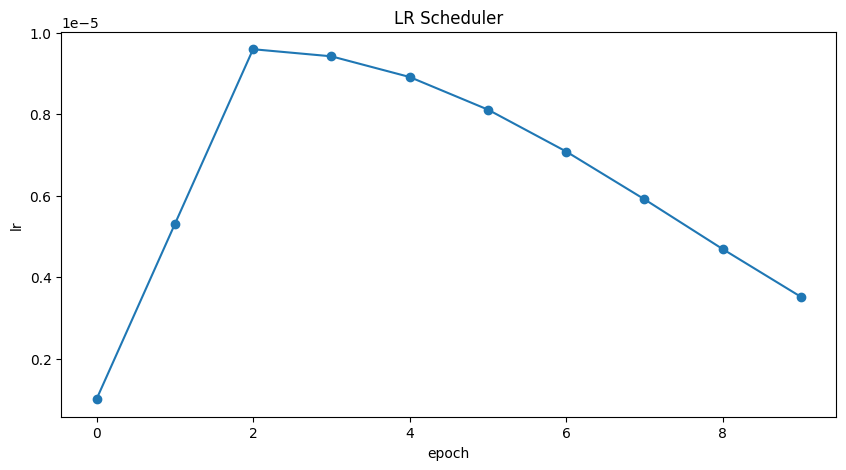

In [ ]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

In [ ]:
ckpt_cb = keras.callbacks.ModelCheckpoint(f'{BASE_PATH}/models/best_model_ns.weights.h5',
                                          monitor='val_log_loss',
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='min')  # Get Model checkpoint callback

In [ ]:
log_loss = keras.metrics.CategoricalCrossentropy(name="log_loss")

In [ ]:
train_ds.take(1)

<_TakeDataset element_spec=({'token_ids': TensorSpec(shape=(None, None, 512), dtype=tf.int32, name=None), 'padding_mask': TensorSpec(shape=(None, None, 512), dtype=tf.bool, name=None), 'len_prompt': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'len_response_a': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'len_response_b': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

In [ ]:
# Define input layers
inputs = {
    "token_ids": keras.Input(shape=(2, None), dtype=tf.int32, name="token_ids"),
    "padding_mask": keras.Input(shape=(2, None), dtype=tf.int32, name="padding_mask"),
    "len_prompt": keras.Input(shape=(1,), dtype=tf.int32, name="len_prompt"),
    "len_response_a": keras.Input(shape=(1,), dtype=tf.int32, name="len_response_a"),
    "len_response_b": keras.Input(shape=(1,), dtype=tf.int32, name="len_response_b"),
    # "sentiment_prompt": keras.Input(shape=(1,), dtype=tf.float32, name="sentiment_prompt"),
    # "sentiment_response_a": keras.Input(shape=(1,), dtype=tf.float32, name="sentiment_response_a"),
    # "sentiment_response_b": keras.Input(shape=(1,), dtype=tf.float32, name="sentiment_response_b"),
}
# Create a DebertaV3Classifier backbone
backbone = keras_nlp.models.DebertaV3Backbone.from_preset(
    CFG.preset,
)

# Compute embeddings for first response: (P + R_A) using backbone
response_a = {k: v[:, 0, :] for k, v in inputs.items() if k in ["token_ids", "padding_mask"]}
embed_a = backbone(response_a)

# Compute embeddings for second response: (P + R_B), using the same backbone
response_b = {k: v[:, 1, :] for k, v in inputs.items() if k in ["token_ids", "padding_mask"]}
embed_b = backbone(response_b)

# Compute final output
embeds = keras.layers.Concatenate(axis=-1)([embed_a, embed_b,])
embeds = keras.layers.GlobalAveragePooling1D()(embeds)
# embeds = keras.layers.Concatenate(axis=-1)([embeds, inputs["len_prompt"], inputs["len_response_a"], inputs["len_response_b"], inputs["sentiment_prompt"], inputs["sentiment_response_a"], inputs["sentiment_response_b"]])
embeds = keras.layers.Concatenate(axis=-1)([embeds, inputs["len_prompt"], inputs["len_response_a"], inputs["len_response_b"]])
outputs = keras.layers.Dense(3, activation="softmax", name="classifier")(embeds)
model = keras.Model(inputs, outputs)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=[
        log_loss,
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, 2, None)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, 2, None)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, None)           │              0 │ padding_mask[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, None)           │              0 │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_7 (GetItem)      │ (None, None)           │              0 │ padding_mask[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_6 (GetItem)      │ (None, None)           │              0 │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ deberta_v3_backbone       │ (None, None, 384)      │     70,682,112 │ get_item_5[0][0],      │
│ (DebertaV3Backbone)       │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_7[0][0],      │
│                           │                        │                │ get_item_6[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, None, 768)      │              0 │ deberta_v3_backbone[0… │
│ (Concatenate)             │                        │                │ deberta_v3_backbone[1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ concatenate_2[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ len_prompt (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ len_response_a            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ len_response_b            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 771)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ len_prompt[0][0],      │
│                           │                        │                │ len_response_a[0][0],  │
│                           │                        │                │ len_response_b[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classifier (Dense)        │ (None, 3)              │          2,316 │ concatenate_3[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 70,684,428 (269.64 MB)

 Trainable params: 70,684,428 (269.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[lr_cb, ckpt_cb]
)

Epoch 1/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 711s 237ms/step - accuracy: 0.2946 - log_loss: 9.6198 - loss: 9.6065 - val_accuracy: 0.2872 - val_log_loss: 9.1802 - val_loss: 9.1645 - learning_rate: 1.0000e-06
Epoch 2/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 644s 216ms/step - accuracy: 0.2942 - log_loss: 8.6136 - loss: 8.6000 - val_accuracy: 0.3012 - val_log_loss: 7.1347 - val_loss: 7.1199 - learning_rate: 5.3000e-06
Epoch 3/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 621s 216ms/step - accuracy: 0.3134 - log_loss: 6.7948 - loss: 6.7824 - val_accuracy: 0.3151 - val_log_loss: 5.9301 - val_loss: 5.9169 - learning_rate: 9.6000e-06
Epoch 4/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 620s 216ms/step - accuracy: 0.3258 - log_loss: 5.7276 - loss: 5.7150 - val_accuracy: 0.3406 - val_log_loss: 5.1461 - val_loss: 5.1345 - learning_rate: 9.4258e-06
Epoch 5/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 621s 216ms/step - accuracy: 0.3424 - log_loss: 5.0672 - loss: 5.0565 - val_accuracy: 0.3415 - val_log_loss: 4.5869 - val_loss: 4.5764 - learni

In [ ]:
model.load_weights(f'{BASE_PATH}/models/best_model_ns.weights.h5')

In [ ]:
valid_texts = valid_df.options.tolist()  # Extract validation texts
valid_prompts_len = valid_df.len_prompt.tolist()
valid_response_a_len = valid_df.len_response_a.tolist()
valid_response_b_len = valid_df.len_response_b.tolist()
valid_sentiment_prompt = valid_df.sentiment_prompt.tolist()
valid_sentiment_response_a = valid_df.sentiment_response_a.tolist()
valid_sentiment_response_b = valid_df.sentiment_response_b.tolist()
test_ds = build_dataset(texts=valid_texts,
                         len_prompt=valid_prompts_len,
                         len_response_a=valid_response_a_len,
                         len_response_b=valid_response_b_len,
                         sentiment_prompt=valid_sentiment_prompt,
                         sentiment_response_a=valid_sentiment_response_a,
                         sentiment_response_b=valid_sentiment_response_b,
                         batch_size=CFG.batch_size, shuffle=False)

In [ ]:
test_preds = model.predict(test_ds, verbose=1)

719/719 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step


In [ ]:
sub_df = valid_df[["id"]].copy()
sub_df[CFG.class_names] = test_preds.tolist()

# Label conversion
sub_df["class_name"] = sub_df[["winner_model_a", "winner_model_b" , "winner_tie"]].idxmax(axis=1)
sub_df["class_label"] = sub_df.class_name.map(CFG.name2label)
sub_df.head()

,id,winner_model_a,winner_model_b,winner_tie,class_name,class_label
28234,2098233919,0.607214,0.221294,0.171492,winner_model_a,0
37422,2789033728,0.992212,0.004103,0.003685,winner_model_a,0
56157,4198930172,0.016138,0.357306,0.626556,winner_tie,2
32269,2396441388,0.882777,0.071849,0.045374,winner_model_a,0
48098,3592485435,0.018189,0.440197,0.541614,winner_tie,2


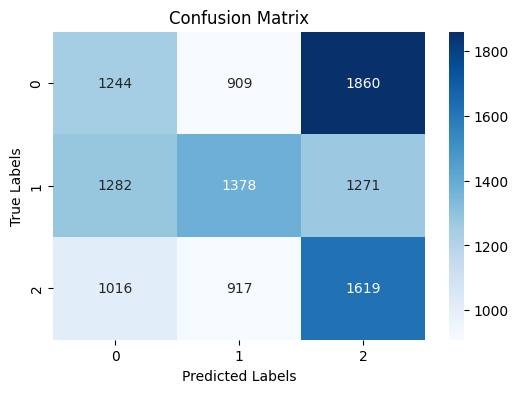

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(valid_df["class_label"], sub_df["class_label"])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_df = pd.read_csv(f'{BASE_PATH}/train.csv')
test_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


# Siamese NN